<a href="https://colab.research.google.com/github/nitinsaimajji/voice1/blob/main/voice_detection_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install python_speech_features module

In [19]:
pip install python_speech_features


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
!git clone https://github.com/nitinsaimajji/voice1.git

fatal: destination path 'voice1' already exists and is not an empty directory.


In [21]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import all modules

In [22]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from python_speech_features import mfcc
from time import time

Load the csv file into data frame

In [24]:
df = pd.read_csv('wav_check.csv')

filename    200
gender      200
dtype: int64

Create two new data frames

In [25]:
df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']


Find out the number of rows

In [26]:
print(df_male.shape)		
# output: (55029, 8) 

(100, 2)


In [27]:
print(df_female.shape)		
print(df_female)
# output: (18249, 8)

(100, 2)
                     filename  gender
100  female-sample-000013.wav  female
101  female-sample-000026.wav  female
102  female-sample-000034.wav  female
103  female-sample-000039.wav  female
104  female-sample-000051.wav  female
..                        ...     ...
195  female-sample-001164.wav  female
196  female-sample-001193.wav  female
197  female-sample-001194.wav  female
198  female-sample-001216.wav  female
199  female-sample-001237.wav  female

[100 rows x 2 columns]


Take only 300 male and 300 female data

In [28]:
df_male = df_male[:100]
df_female = df_female[:100]

Define the audio path

In [ ]:
# TRAIN_PATH = '/content/voice/cv-valid-train/'

The function to convert mp3 to wav

In [ ]:
# def convert_to_wav(df, m_f, path=TRAIN_PATH):
#     srcs = []
#     for file in tqdm(df['filename']):
#         sound = AudioSegment.from_mp3(path+file)
        
# 		# Create new wav files based on existing mp3 files
#         if m_f == 'male':
#             sound.export('male-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
#         elif m_f == 'female':
#             sound.export('female-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        
#     return

How to use the convert_to_wav() function

In [ ]:
#convert_to_wav(df_male, m_f='male')


 85%|████████▌ | 85/100 [00:16<00:02,  5.02it/s]


FileNotFoundError: ignored

In [ ]:
# convert_to_wav(df_female, m_f='female')

100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


In [29]:
TRAIN_PATH = '/content/voice1/dataset/'

Define a function to load the raw audio files

In [30]:
def load_audio(path=TRAIN_PATH):
	# Allocate empty list for male and female voices
    male_voices = []
    female_voices = []
    for file in tqdm(df['filename']):
        if file.split('-')[0] == 'male':
            male_voices.append(librosa.load(path+file))
        elif file.split('-')[0] == 'female':
            female_voices.append(librosa.load(path+file))
    
	# Convert the list into Numpy array
    male_voices = np.array(male_voices)
    female_voices = np.array(female_voices)
    
    return male_voices, female_voices

In [17]:
# def convert_to_wav(df, m_f, path=TRAIN_PATH):
#     srcs = []
#     for file in tqdm(df['filename']):
#         sound = AudioSegment.from_mp3(path+file)
        
# 		# Create new wav files based on existing mp3 files
#         if m_f == 'male':
#             sound.export('male-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
#         elif m_f == 'female':
#             sound.export('female-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        
#     return

How to use load_audio() function

In [32]:
male_voices, female_voices = load_audio()

100%|██████████| 200/200 [00:45<00:00,  4.42it/s]
<ipython-input-30-1eec0c28e137>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  male_voices = np.array(male_voices)
<ipython-input-30-1eec0c28e137>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  female_voices = np.array(female_voices)


The function to extract audio features

In [33]:
def extract_features(audio_data):
	audio_waves = audio_data[:,0]
	samplerate = audio_data[:,1][1]
	
	features = []
	for audio_wave in tqdm(audio_waves):
		features.append(mfcc(audio_wave, samplerate=samplerate, numcep=26))
    
	features = np.array(features)
	return features

In [34]:
print(male_voices.shape)

(100, 2)


Use the extract_features() function

In [35]:
male_features = extract_features(male_voices)
female_features = extract_features(female_voices)

100%|██████████| 100/100 [00:02<00:00, 47.90it/s]
<ipython-input-33-1d3dd38f60c7>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)
100%|██████████| 100/100 [00:02<00:00, 47.12it/s]


The function used to concatenate all audio features forming a long 2-dimensional array

In [36]:
def concatenate_features(audio_features):
    concatenated = audio_features[0]
    for audio_feature in tqdm(audio_features):
        concatenated = np.vstack((concatenated, audio_feature))
        
    return concatenated

How the function is used

In [37]:
male_concatenated = concatenate_features(male_features)
female_concatenated = concatenate_features(female_features)

100%|██████████| 100/100 [00:00<00:00, 948.30it/s]


In [58]:
print(male_concatenated.shape) 		
# Output: (117576, 26)

(40177, 26)


array([[-4.58530226e+01, -1.66091542e+01,  6.23374869e+00, ...,
         1.78087548e-02,  3.88462524e-02,  2.60186666e-02],
       [-1.36576124e+01, -2.59483273e+01,  5.45621343e+00, ...,
        -1.75421865e-01, -5.48513474e-01, -1.78101623e-01],
       [-1.23649804e+01, -2.96121607e+01, -3.97292244e+00, ...,
        -2.33953848e-01, -8.32843352e-01, -9.43240378e-01],
       ...,
       [-1.40038044e+01, -1.45516479e+01, -3.00557154e+00, ...,
         1.19844517e-01,  5.82003013e-01,  2.88646639e-01],
       [-1.49710026e+01, -9.96157603e+00,  6.39030454e+00, ...,
         1.59949544e-01,  7.54141482e-01,  9.21275103e-01],
       [-1.65170106e+01, -1.14356303e+01, -2.95354003e+00, ...,
         1.13117028e-02, -6.03423208e-02,  2.44701815e-01]])

In [39]:
print(female_concatenated.shape)	
# Output: (124755, 26)

(40816, 26)


Concatenate male voices and female voices

In [124]:
X = np.vstack((male_concatenated, female_concatenated))
X=X[0:100000]

Create labels

In [125]:
y = np.append([0] * len(male_concatenated), [1] * len(female_concatenated))
y=y[0:100000]

Check whether X and y are already having the exact same length

In [126]:
print(X.shape)		
# Output: (242268, 26)

(80993, 26)


In [127]:
print(y.shape)		
# Output: (242268,)

(80993,)


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [135]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=22)

In [136]:
X_train.shape

(36284, 26)

MLP

In [137]:
import keras
from keras.models import Sequential
from keras. layers import Dense, Dropout, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(400,activation='relu',input_dim=26))
model.add(Dense(200,activation='relu'))
model.add(Dense(20,activation='softmax'))

sgd=SGD(lr=0.01,decay=1e-6,momentum=0.9,nesterov=True)
model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1134/1134 [==============================] - 6s 5ms/step - loss: 0.5949 - accuracy: 0.7069 - val_loss: 0.5088 - val_accuracy: 0.7463
Epoch 2/20
1134/1134 [==============================] - 6s 6ms/step - loss: 0.5037 - accuracy: 0.7493 - val_loss: 0.4997 - val_accuracy: 0.7501
Epoch 3/20
1134/1134 [==============================] - 5s 4ms/step - loss: 0.4711 - accuracy: 0.7680 - val_loss: 0.4897 - val_accuracy: 0.7558
Epoch 4/20
1134/1134 [==============================] - 6s 5ms/step - loss: 0.4441 - accuracy: 0.7852 - val_loss: 0.4790 - val_accuracy: 0.7678
Epoch 5/20
1134/1134 [==============================] - 5s 4ms/step - loss: 0.4273 - accuracy: 0.7963 - val_loss: 0.4759 - val_accuracy: 0.7713
Epoch 6/20
1134/1134 [==============================] - 6s 5ms/step - loss: 0.4101 - accuracy: 0.8049 - val_loss: 0.4451 - val_accuracy: 0.7940
Epoch 7/20
1134/1134 [==============================] - 6s 5ms/step - loss: 0.3900 - accuracy: 0.8177 - val_loss: 0.4365 - val_accuracy:

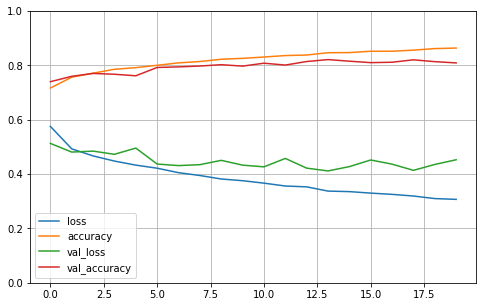

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [132]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')


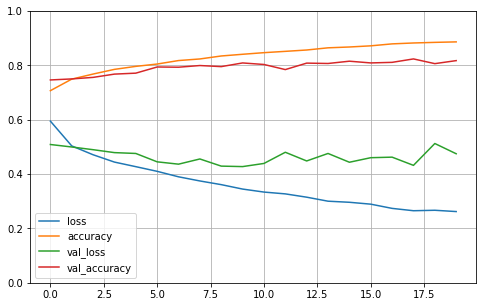

In [138]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [70]:
X_new = X_test[:5]
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 33ms/step


array([0, 0, 0, 1, 0])

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test[:5],y_pred)*100
print("accuracy is "+str(accuracy))

accuracy is 40.0


Initialize SVM model

In [ ]:
clf = SVC(kernel='rbf')      

Train the model

In [ ]:
start = time()
model=clf.fit(X_train[:50000], y_train[:50000])
print(time()-start)						
# Output: 184.8018662929535 (seconds)

165.91033482551575


In [ ]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=262121 sha256=00ec78d1e91faf62199cf6870a42d639e798503094d02cca5ccc96549f7d1326
  Stored in directory: /root/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5


In [ ]:
import pickle5 as pickle
  
# Save the trained model as a pickle string.
saved_model = pickle.dumps(clf)
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
# Load the pickled model
model = pickle.loads(saved_model)

Compute the accuracy score towards train data

In [ ]:
start = time()
print(clf.score(X_train[:50000], y_train[:50000]))		
# Output: 0.78204

0.83466


In [ ]:
print(time()-start)						
# Output: 90.8693311214447 (seconds)

109.30222392082214


Compute the accuracy score towards test data

In [ ]:
start = time()
print(clf.score(X_test[:10000], y_test[:10000]))		
# Output: 0.7679

In [ ]:
print(time()-start)						
# Output: 18.082067728042603 (seconds)

Predict the first 10000 test data

In [ ]:
svm_predictions = clf.predict(X_test[:10000])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test[:10000],svm_predictions)*100
print("accuracy is "+str(accuracy))

accuracy is 82.07


Create the confusion matrix values

In [ ]:
cm = confusion_matrix(y_test[:10000], svm_predictions)

Create the confusion matrix display

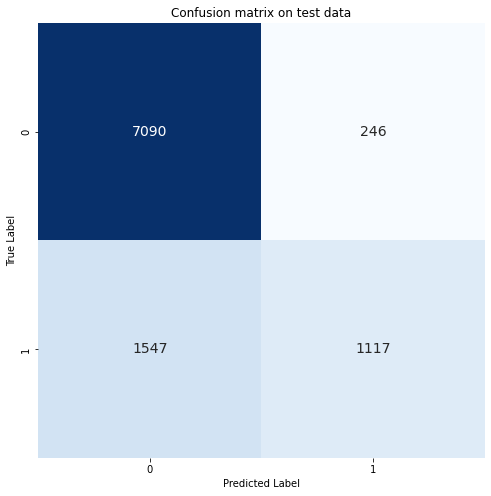

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Confusion matrix on test data')
sns.heatmap(cm, annot=True, fmt='d', 
            cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Performance comparison between different algorithms

In [ ]:
index = ['SVM-RBF', 'SVM-Poly', 'SVM-Sigmoid', 'Logistic Regression']

I record all the results below manually

In [ ]:
values = [184.8, 137.0, 283.6, 0.7]

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Training duration (lower is better)')
plt.xlabel('Seconds')
plt.ylabel('Model')
plt.barh(index, values, zorder=2)
plt.grid(zorder=0)

In [ ]:
for i, value in enumerate(values):
    plt.text(value+20, i, str(value)+' secs', fontsize=12, color='black',
             horizontalalignment='center', verticalalignment='center')

In [ ]:
plt.show()

set width of bar

In [ ]:
barWidth = 0.25
    
index = ['SVM-RBF', 'SVM-Poly', 'SVM-Sigmoid', 'Logistic Regression']

set height of bar<br>
I record all the results below manually

In [ ]:
train_acc = [78.2, 74.8, 74.8, 65.8]
test_acc = [76.8, 74.3, 74.3, 65.8]
 
# Set position of bar on X axis
baseline = np.arange(len(train_acc))
r1 = [x + 0.125 for x in baseline]
r2 = [x + 0.25 for x in r1]
 
# Make the plot
plt.figure(figsize=(16,9))
plt.title('Model performance (higher is better)')
plt.bar(r1, train_acc, width=barWidth, label='Train', zorder=2)
plt.bar(r2, test_acc, width=barWidth, label='Test', zorder=2)
plt.grid(zorder=0)
 
# Add xticks on the middle of the group bars
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks([r + barWidth for r in range(len(train_acc))], index)

Create text

In [ ]:
for i, value in enumerate(train_acc):
    plt.text(i+0.125, value-5, str(value), fontsize=12, color='white',
             horizontalalignment='center', verticalalignment='center')
    
for i, value in enumerate(test_acc):
    plt.text(i+0.375, value-5, str(value), fontsize=12, color='white',
             horizontalalignment='center', verticalalignment='center')
    
plt.legend()
plt.sho

In [ ]:
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# print(loaded_model.predict(X_test[:10000]))
result = loaded_model.score(X_test[:10], y_test[:10])
print(result)

0.9


In [ ]:
predict=loaded_model.predict(X_test[:1])
print(predict)

[0]
accuracy is 0.0


In [ ]:
print(y_test[:5])

[1 0 0 0 0]
